## Importing libraries

In [1]:
import os
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import load_model
from IPython.display import Audio
from gtts import gTTS
import cv2

In [2]:
BASE_DIR = 'E:/downloadE/6th_sem_projects/IT414-2/input'
WORKING_DIR = 'E:/downloadE/6th_sem_projects/IT414-2/working'

In [3]:
# loading vgg16 model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 694s 1us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

## Extracting Image Features

In [11]:
features = {}
directory = os.path.join(BASE_DIR, r'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [12]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [3]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [4]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [5]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [6]:
len(mapping)

8091

## Preprocess Text Data

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [10]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
clean(mapping)

In [12]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
len(all_captions)

40455

In [15]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [16]:
# tokenizing  text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
vocab_size

8485

In [18]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [20]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

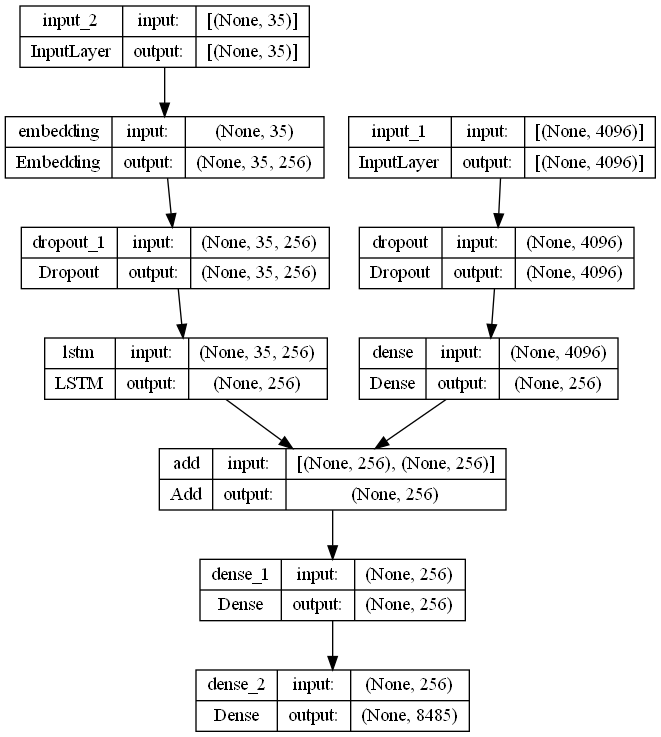

In [21]:
# encoder
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plotting the model
plot_model(model, show_shapes=True)

## Training the Model

In [20]:
epochs = 10
batch_size = 16
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [21]:
model.save(WORKING_DIR+'/best_model.h5')

In [22]:
model = load_model(WORKING_DIR+'/best_model.h5')

## Generate caption for image

In [23]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [24]:
# generating caption for an image
def predict_caption(model, image, tokenizer, max_length):
    
    in_text = 'startseq'
    
    for i in range(max_length):      
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

In [39]:
# validating 
actual, predicted = list(), list()

for key in tqdm(test):
    
    captions = mapping[key]
    
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
   
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.528503
BLEU-2: 0.300806


## Visualizing results

In [25]:
def generate_caption(image_name):
   
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    #Prediction
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq blond child is playing with metal yard ornament endseq
startseq child dressed in blue sits next to plants endseq
startseq child in blur shirt playing in flower bed endseq
startseq child plays outside by garden endseq
startseq small child is sitting playing with an adornment in small garden endseq
--------------------Predicted--------------------
startseq child in blur shirt is playing with red toy ornament endseq


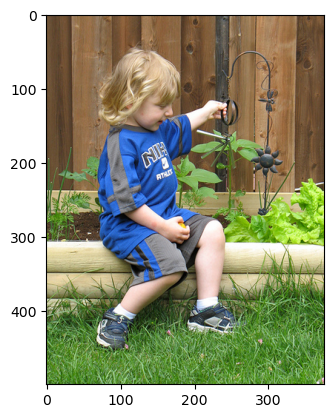

In [26]:
generate_caption("3738685861_8dfff28760.jpg")

---------------------Actual---------------------
startseq boy pitches in baseball game endseq
startseq boy winding up for pitch endseq
startseq young baseball player winds up to throw the ball endseq
startseq young person pitches in baseball game endseq
startseq the baseball player is throwing the ball endseq
--------------------Predicted--------------------
startseq baseball player pitches in baseball game endseq


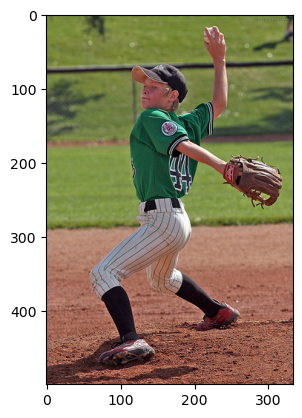

In [27]:
generate_caption("3744832122_2f4febdff6.jpg")

## Test with real images

In [28]:
vgg_model = VGG16()

vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [29]:
def test_func(img):
    image = img_to_array(img)
   
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    image = preprocess_input(image)
    
    feature = vgg_model.predict(image, verbose=0)

    cap_ = predict_caption(model, feature, tokenizer, max_length)
    return cap_

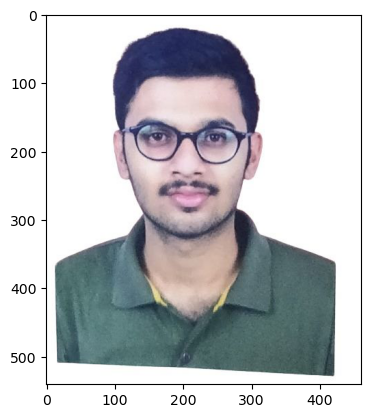

man wearing glasses and sunglasses is smiling 


In [33]:
image_path = 'E:/downloadE/6th_sem_projects/IT414-2/test/test_img6.jpg'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Loading the image
img_ = mpimg.imread(image_path)

# Show the image
plt.imshow(img_)
plt.show()
image = load_img(image_path, target_size=(224, 224))
capt  = test_func(image)
capt = capt[9:-6]
print(capt)
voice_gen(capt)
# # convert image pixels to numpy array
# image = img_to_array(image)
# # reshape data for model
# image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# # preprocess image for vgg
# image = preprocess_input(image)
# # extract features
# feature = vgg_model.predict(image, verbose=0)
# # predict from the trained model
# cap_ = predict_caption(model, feature, tokenizer, max_length)

In [30]:
#capt

In [32]:
def voice_gen(capt):

    language = 'gu'

    myobj = gTTS(text=capt, lang=language, slow=False)

    myobj.save("voice4.mp3")

    audio = Audio("voice4.mp3", autoplay=True)
    display(audio)

In [45]:
cap = cv2.VideoCapture(0)

cap.set(cv2.CAP_PROP_FPS, 5)

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)
while True:
    ret, frame = cap.read()
    cv2.imshow('Webcam', frame)
    key = cv2.waitKey(1)
    if key == ord('q'): # Press 'q' to exit
        break
    elif key == ord('p'): # Press 'p' to capture and predict the image
        frame = cv2.resize(frame, (224, 224))
        img_capt = test_func(frame)
        img_capt = img_capt[9:-7]
        print(img_capt)
        voice_gen(img_capt)
        cv2.destroyAllWindows()  
        break
cap.release()

man wearing red jacket is standing in front of red building


In [44]:
cap = cv2.VideoCapture(0)

fps = cap.get(cv2.CAP_PROP_FPS)
print("Frame rate:", fps)

cap.release()

Frame rate: 30.0
